In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,learning_curve,LearningCurveDisplay
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score,classification_report,log_loss,confusion_matrix, ConfusionMatrixDisplay
sns.set_style(style='whitegrid', rc={'figure.figsize': (10, 10)})
%matplotlib inline

In [2]:
#load the data and see it
data=pd.read_csv('marketing_AB.csv')
data.head(5)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
data=data.drop('Unnamed: 0',axis=1)#get rid of the weird column
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [4]:
data.info()#general info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [5]:
data.describe()#descriptive statistics

,user id,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


In [6]:
data.nunique()#unique values in each column

user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

In [7]:
data.shape#checking data shape

(588101, 6)

In [8]:
data['test group'].unique()#checking unique values for test group tp see its relationship with our data

array(['ad', 'psa'], dtype=object)

In [9]:
vari=data.drop('user id', axis=1)#dropping the not helpful column
vari.head()

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


In [10]:
def countsofconverted(col):#visualizations function for easier coding
    sns.countplot(data=vari,x=col,hue='converted')
    plt.show()

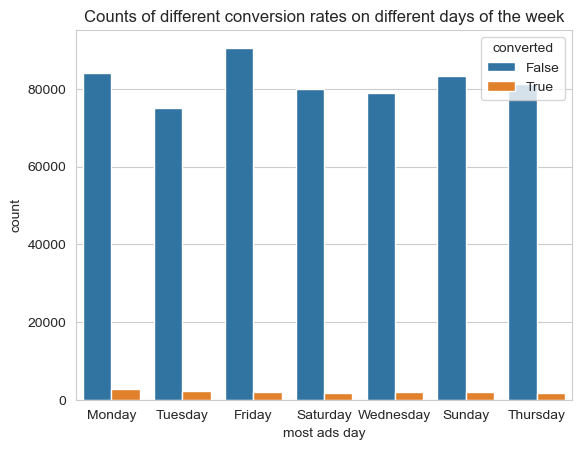

In [49]:
plt.title('Counts of different conversion rates on different days of the week')
countsofconverted('most ads day')

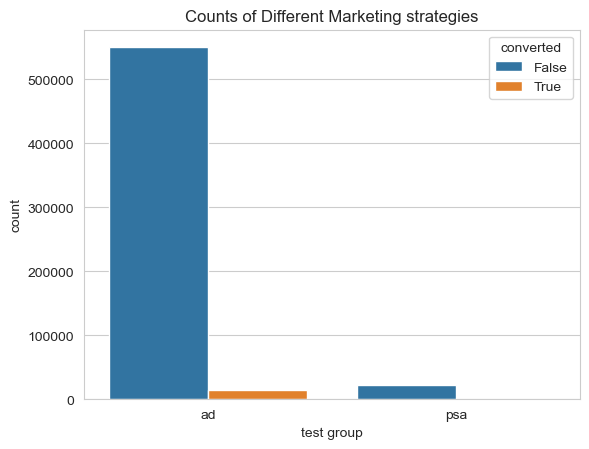

In [46]:
plt.title('Counts of Different Marketing strategies')
countsofconverted('test group')

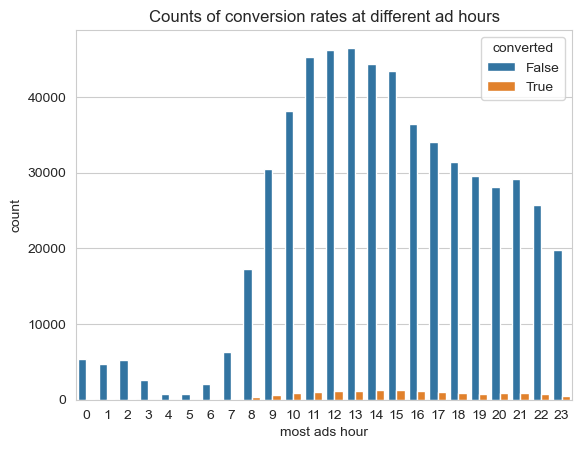

In [48]:
plt.title('Counts of conversion rates at different ad hours')
countsofconverted('most ads hour')

As we can see, most users are not active in the early hours of the morning and are more likely to not convert

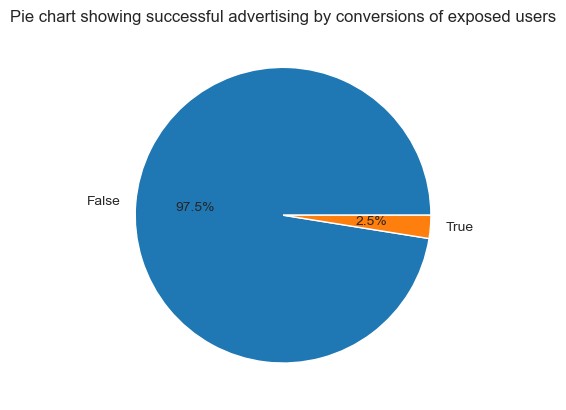

In [51]:
plt.title('Pie chart showing successful advertising by conversions of exposed users')
plt.pie(vari['converted'].value_counts(),
    explode=None,
    labels=['False','True'],
    colors=None,
    autopct='%1.1f%%',
    pctdistance=0.6)
plt.show()

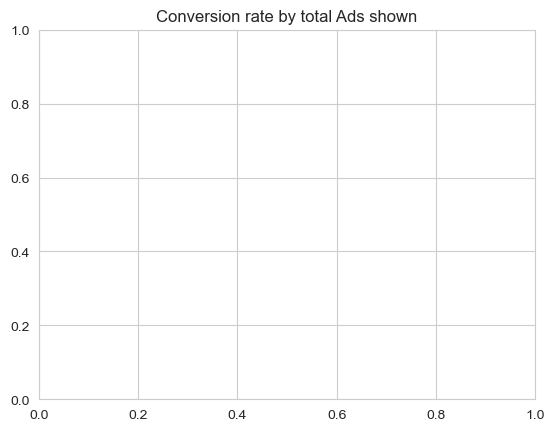

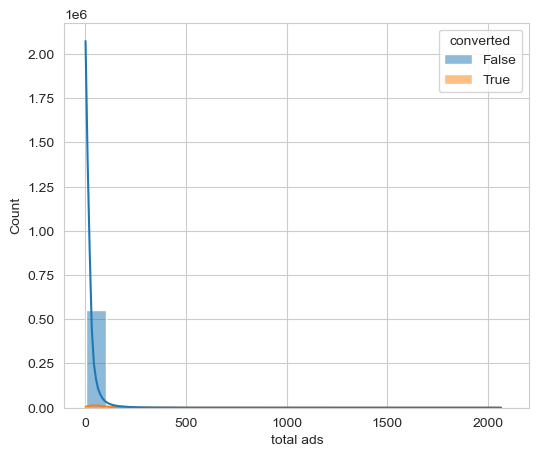

In [52]:
plt.title('Conversion rate by total Ads shown')
plt.figure(figsize=(6,5))
sns.histplot(data=vari, x='total ads', hue='converted',binwidth=100,kde=True)
plt.show()

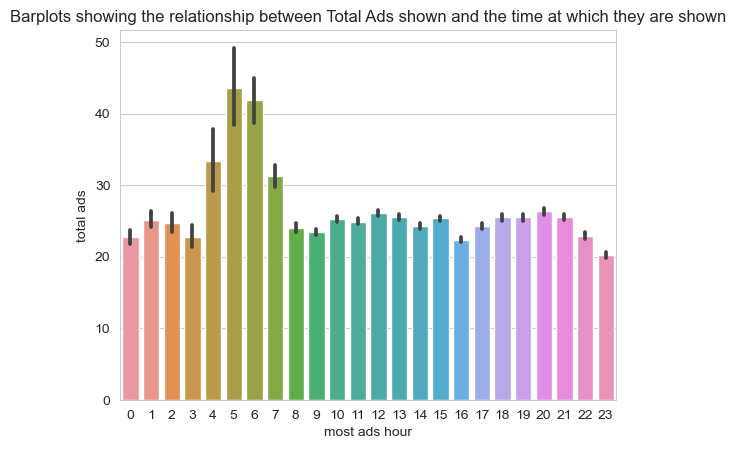

In [41]:
sns.barplot(data=vari, x='most ads hour',y='total ads')
plt.title('Barplots showing the relationship between Total Ads shown and the time at which they are shown')
plt.show()

As seen in this barplot, most users between 4am to 7am are shown the most ads. And these times are not the best for us for advertisement, as most people awake by that time are less likely to be interested in watching an ad. Except we can change the format of ads shown within the early hours of the morning.

From the visualisations above, it is clear that this is a very very very very very very imbalanced dataset. In order to get a better view of the cases that users were converted, I'll create a separate dataframe for the true option. Then visualise the data, making it so much easier to focus on the strengths of the our advertising campaign.

In [15]:
false_df= vari[vari['converted']== False]
true_df= vari[vari['converted']== True]#dataset for just true values

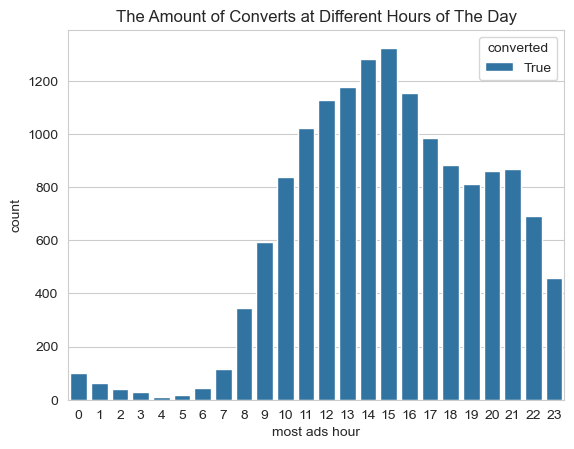

In [42]:
sns.countplot(data=true_df, x='most ads hour',hue='converted')
plt.title('The Amount of Converts at Different Hours of The Day')
plt.show()

Between 10am to around 6pm is when most of our ads convert and generally the time when most users are receptive to ads. The early mornings are terrible timings and as we can see the data is rightly skewed.

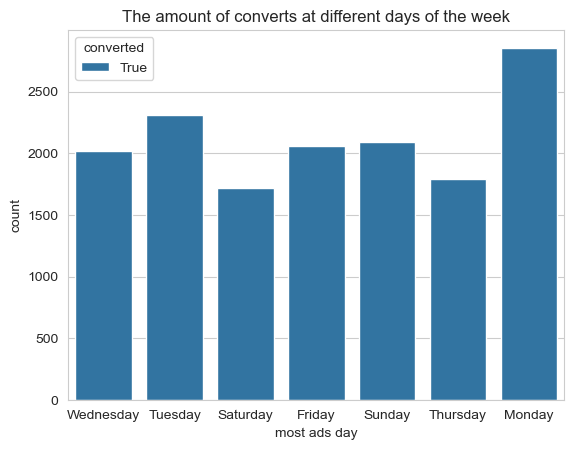

In [43]:
sns.countplot(data=true_df, x='most ads day',hue='converted')
plt.title('The amount of converts at different days of the week')
plt.show()

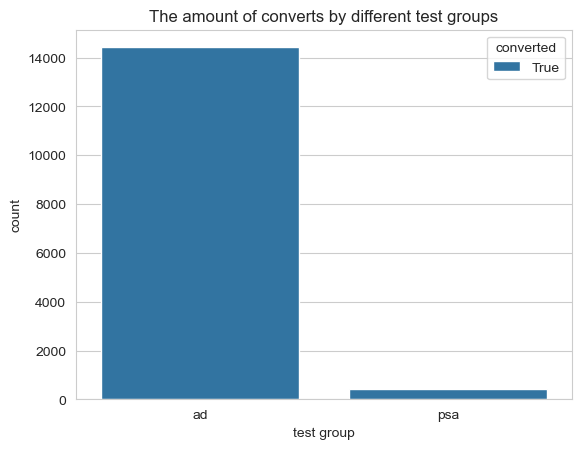

In [44]:
sns.countplot(data=true_df, x='test group',hue='converted')
plt.title('The amount of converts by different test groups')
plt.show()

In [22]:
vari.isnull().sum()#check for missing values

test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [23]:
vari.head()#data check

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


We are going to conduct an AB testing below to check if truly the different marketing strategies have a statistically significant difference or it is just the imbalanced dataset at work.

In [24]:
grouped = vari.groupby(['test group','converted']).agg(count=('converted', 'count')).reset_index()
grouped.head()#creating a new dataframe for the grouped feature by test group

,test group,converted,count
0,ad,False,550154
1,ad,True,14423
2,psa,False,23104
3,psa,True,420


In [25]:
grouped=grouped.pivot(index='test group',columns='converted',values='count')#pivot it/you could have used unstack above to makea contingency table
chi2stat, p_value, dof, expected=stats.chi2_contingency(grouped)#I overwrote it on the former df because it was not that useful
print('Contigency table:')
print(grouped)
print('\nChi-square stats',chi2stat.round(2))
print('P-value',p_value.round(2))
print('Degrees of freedom',dof)
print('Expected frequencies\n',expected)

Contigency table:
converted    False  True 
test group               
ad          550154  14423
psa          23104    420

Chi-square stats 54.01
P-value 0.0
Degrees of freedom 1
Expected frequencies
 [[550327.71899045  14249.28100955]
 [ 22930.28100955    593.71899045]]


We reject the null hypothesis because our pvalue is less than 0.05, which means there is a statistically significant difference between the two test groups

In [26]:
grouped = vari.groupby(['most ads day','converted']).agg(count=('converted', 'count')).reset_index()#performing the same test for most ads day
grouped=grouped.pivot(index='most ads day',columns='converted',values='count')
chi2stat, p_value, dof, expected=stats.chi2_contingency(grouped)
print('Contigency table:')
print(grouped)
print('\nChi-square stats',chi2stat.round(2))
print('P-value',p_value.round(2))
print('Degrees of freedom',dof)
print('Expected frequencies\n',expected)

Contigency table:
converted     False  True 
most ads day              
Friday        90551   2057
Monday        84216   2857
Saturday      79941   1719
Sunday        83301   2090
Thursday      81192   1790
Tuesday       75167   2312
Wednesday     78890   2018

Chi-square stats 410.05
P-value 0.0
Degrees of freedom 6
Expected frequencies
 [[90270.67946492  2337.32053508]
 [84875.37656627  2197.62343373]
 [79598.99452645  2061.00547355]
 [83235.82833221  2155.17166779]
 [80887.62875084  2094.37124916]
 [75523.51820861  1955.48179139]
 [78865.9741507   2042.0258493 ]]


We reject the null hypothesis because our pvalue is less than 0.05, which means there is a statistically significant difference between the days  most ads were shown

In [27]:
ohe=OneHotEncoder(sparse_output=False, drop='first')#handling of categorical variables timeee
coded_cols=ohe.fit_transform(vari[['test group','most ads day']])
coded_df=pd.DataFrame(coded_cols, columns=ohe.get_feature_names_out(['test group','most ads day']))

coded_data=pd.concat([vari.drop(['test group','most ads day'],axis=1),coded_df], axis=1)#drop the originals and add the coded
coded_data.head()

,converted,total ads,most ads hour,test group_psa,most ads day_Monday,most ads day_Saturday,most ads day_Sunday,most ads day_Thursday,most ads day_Tuesday,most ads day_Wednesday
0,False,130,20,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,False,93,22,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,False,21,18,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,False,355,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,False,276,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0


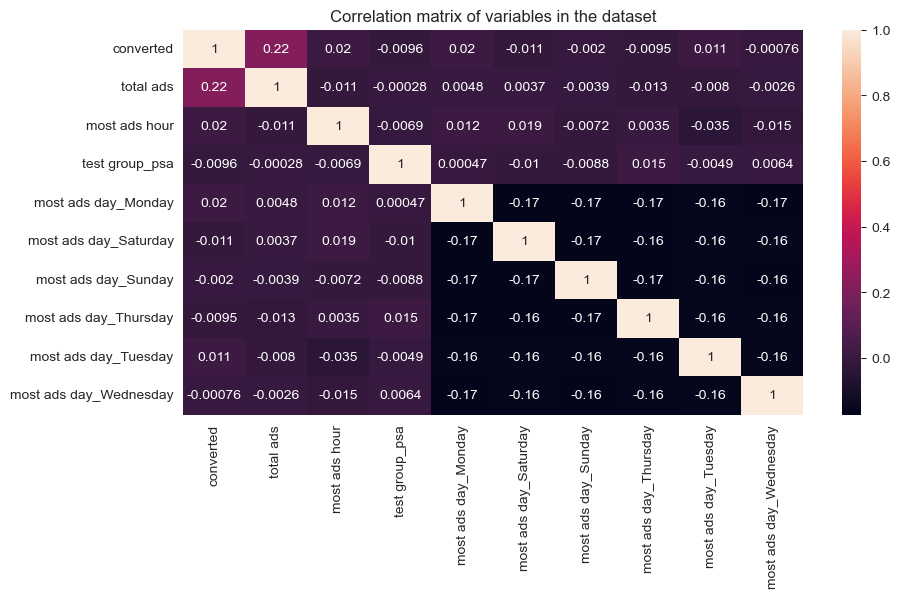

In [53]:
plt.figure(figsize=(10,5))
sns.heatmap(coded_data.corr(), annot=True)
plt.title('Correlation matrix of variables in the dataset')
plt.show()

In [29]:
X=coded_data.drop('converted', axis=1)#split into target and independent variable
y=coded_data['converted']

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X, y,test_size=0.2, random_state=42)#split and create log regression model
lr=LogisticRegression(max_iter=1000,random_state=42)

In [31]:
# Combine the training data back together
X_train_combined = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
minority = X_train_combined[X_train_combined['converted'] == True ]
majority = X_train_combined[X_train_combined['converted'] == False]

majority_downsampled = resample(majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(minority), # to match minority class
                                 random_state=42) # reproducible results

# Combine majority and oversampled minority
balanced_data = pd.concat([majority_downsampled, minority])
X_train_balanced = balanced_data.drop('converted', axis=1)
y_train_balanced = balanced_data['converted']


In [32]:
#fit, predict,evaluate
lr.fit(X_train_balanced,y_train_balanced)
ypred=lr.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.99      0.86      0.92    114632
        True       0.12      0.69      0.20      2989

    accuracy                           0.86    117621
   macro avg       0.55      0.78      0.56    117621
weighted avg       0.97      0.86      0.90    117621



In [33]:
#A learning curve to understand model performance
train_sizes, train_scores, test_scores = learning_curve(lr, X_train_balanced, y_train_balanced, train_sizes=np.linspace(0.1, 1.0, 5),cv=5, scoring='accuracy',random_state=42)
for train_size, cv_train_scores, cv_test_scores in zip(train_sizes, train_scores, test_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

1896 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
6163 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
10431 samples were used to train the model
The average train accuracy is 0.91
The average test accuracy is 0.54
14698 samples were used to train the model
The average train accuracy is 0.78
The average test accuracy is 0.72
18966 samples were used to train the model
The average train accuracy is 0.78
The average test accuracy is 0.78


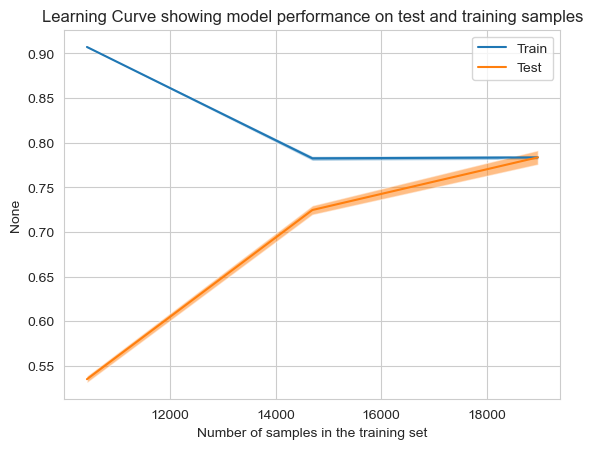

In [54]:
display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=test_scores)
display.plot()#view on the learning curve
plt.title('Learning Curve showing model performance on test and training samples')
plt.show()

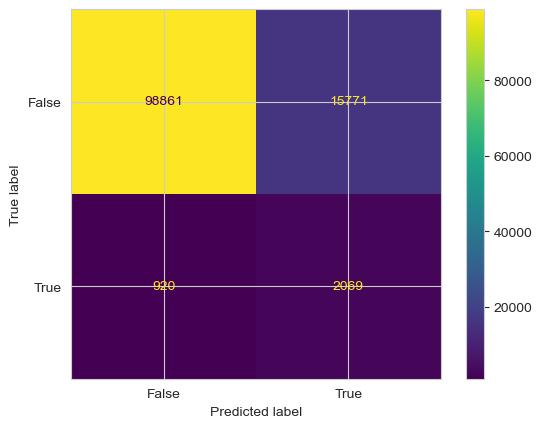

In [55]:
#confusion matrix for a more exquisite view on model performance
cf=confusion_matrix(y_test, ypred)
cmd= ConfusionMatrixDisplay(cf,display_labels=lr.classes_)
plt.show('Confusion matrix for model predictions')
cmd.plot()
plt.show()

In [36]:
#create a dataframe for the ratings of the features according to our logistic regression model
feat_imp=pd.DataFrame({'features': X.columns,'importance': lr.coef_[0]
                     }).sort_values(by='importance', ascending=False).reset_index()
feat_imp.head(9)

,index,features,importance
0,3,most ads day_Monday,0.383221
1,7,most ads day_Tuesday,0.350514
2,8,most ads day_Wednesday,0.206910
3,5,most ads day_Sunday,0.131144
4,0,total ads,0.032404
5,1,most ads hour,0.026548
6,6,most ads day_Thursday,0.004601
7,4,most ads day_Saturday,-0.131862
8,2,test group_psa,-0.273682


The days the Ads were shown seem to be the most important features according to our model. Monday-Wednesday being the most important.

In [37]:
dtree=DecisionTreeClassifier(ccp_alpha=0.02,random_state=42)#a second model for experimentation sake
dtree.fit(X_train_balanced,y_train_balanced)
ypreddt=dtree.predict(X_test)

In [38]:
print(classification_report(ypreddt,y_test))#evaluation of the new model

              precision    recall  f1-score   support

       False       0.82      0.99      0.90     95191
        True       0.75      0.10      0.18     22430

    accuracy                           0.82    117621
   macro avg       0.79      0.55      0.54    117621
weighted avg       0.81      0.82      0.76    117621



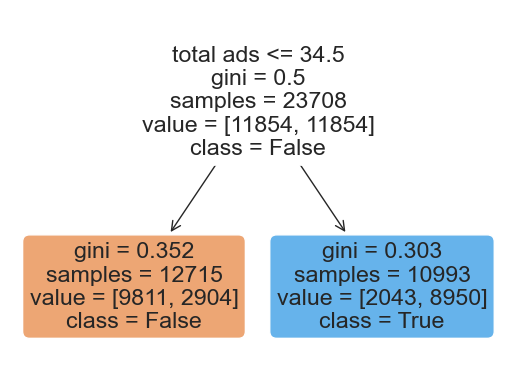

In [39]:
plot_tree(dtree,class_names=['False','True'],feature_names=X_train.columns.to_list(),filled=True,rounded=True,)
plt.show()#a little visual because why not?

In [40]:
#create a dataframe for the ratings of the features according to decision tree model
feature_importance_dtree=pd.DataFrame({'features': X.columns,'importance': dtree.feature_importances_
                     }).sort_values(by='importance', ascending=False).reset_index()
feature_importance_dtree.head(5)

,index,features,importance
0,0,total ads,1.0
1,1,most ads hour,0.0
2,2,test group_psa,0.0
3,3,most ads day_Monday,0.0
4,4,most ads day_Saturday,0.0


The most important and only regarded feature seems to be total ads. This model therefore i not the most idle for this imbalanced dataset

Byeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee!!!